# Data Pre-Processing

## Description
This notebook prepares the raw and cleaned PD control datasets for model training. 

## Author
- Sophia Chiang
- June 12th 2024

In [237]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import pickle
from project_functions import save_data_to_csv

In [238]:
# Input training data

# Specify maps used for training to find training data folders in current directory
train_maps = ['4way', 'small_loop', 'small_loop_cw', 'straight_road', 'zigzag_dists']
train_folders = [f"train_data/train_data_{map_name}" for map_name in train_maps]

# Define pattern to match .csv files
pattern = '*.csv'

# List to store csv file paths
csv_fps = []

# Iterate through file paths
for folder in train_folders:
    csv_files = glob.glob(os.path.join(folder, pattern)) # Get all csvs in current folder
    csv_fps.extend(csv_files) # Extend list of csv file paths with files in current folder


## PD - Raw Data

In [239]:
# Initialise master dataframe of all training data
df = pd.concat([pd.read_csv(fp) for fp in csv_fps], ignore_index=True)

df.drop('timestep', axis=1, inplace=True)
df.drop('car_speed', axis=1, inplace=True)
df.drop('total_reward', axis=1, inplace=True)

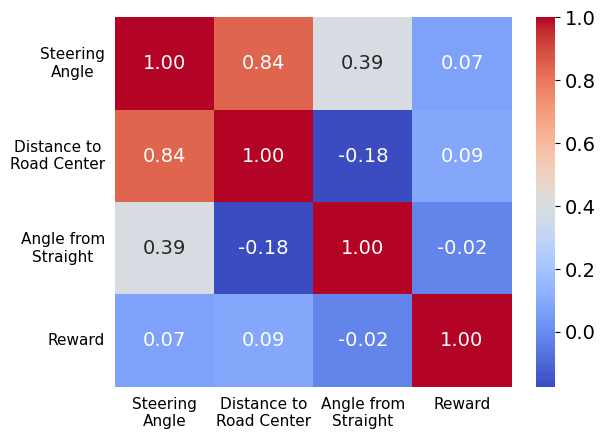

In [240]:
# Compute correlation matrix
corr_matrix = df.corr()

# Visualise matrix
ax = plt.gca()
heatmap = sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            annot_kws={"size": 14})

labels = ['Steering\nAngle', 'Distance to\nRoad Center', 'Angle from\nStraight', 'Reward']
ax.set_xticks([x + 0.5 for x in range(len(labels))])
ax.set_yticks([y + 0.5 for y in range(len(labels))])
ax.set_xticklabels(labels, ma='center', rotation=0, size=11)
ax.set_yticklabels(labels, ma='center', rotation=0, size=11)
ax.tick_params(left=False, bottom=False)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

In [241]:
# Perform data normalisation
print("DNN training data before normalisation:")
display(df)

# Normalise data
scaler = StandardScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Store scaling parameters
scaling_params = {
    'mean': scaler.mean_,
    'scale': scaler.scale_
}

# Create folder for models
if not os.path.exists("train_data"):
    os.makedirs("train_data")

# Save scaling parameters
with open('train_data/raw_data_pd_scaling_params.pkl', 'wb') as file:
    pickle.dump(scaling_params, file)

print("DNN training data after normalisation:")
display(df_norm)

# Print scaling parameters
scaling_params_df = pd.DataFrame(columns=df_norm.columns)
scaling_params_df.loc[len(scaling_params_df)] = scaler.mean_
scaling_params_df.loc[len(scaling_params_df)] = scaler.scale_
scaling_params_df = scaling_params_df.rename(index={0: 'mean', 1: 'scale'})
print("Scaling parameters for normalisation:")
display(scaling_params_df)

DNN training data before normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,1.205219,0.043588,0.769343,0.426165
1,1.205219,0.043588,0.769343,0.426165
2,1.205219,0.043588,0.769343,0.426165
3,1.205219,0.043588,0.769343,0.426165
4,1.205219,0.043588,0.769343,0.425457
...,...,...,...,...
124995,0.067777,0.005244,0.015342,-8.172504
124996,0.067025,0.005278,0.014245,-8.124356
124997,0.066256,0.005310,0.013157,-8.075805
124998,0.065469,0.005339,0.012076,-8.026854


DNN training data after normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,2.588463,1.026888,2.956561,-0.012300
1,2.588463,1.026888,2.956561,-0.012300
2,2.588463,1.026888,2.956561,-0.012300
3,2.588463,1.026888,2.956561,-0.012300
4,2.588463,1.026888,2.956561,-0.012614
...,...,...,...,...
124995,0.144081,0.147693,0.010285,-3.835282
124996,0.142465,0.148484,0.006000,-3.813875
124997,0.140811,0.149215,0.001745,-3.792289
124998,0.139120,0.149889,-0.002478,-3.770526


Scaling parameters for normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
mean,0.000732,-0.001198,0.012710,0.453830
scale,0.465329,0.043613,0.255917,2.249205


For 4 components:
Singular values: [4.84928369e+02 3.78238040e+02 3.48970575e+02 3.57861365e-13]
Variance ratios: [4.70311046e-01 2.86128029e-01 2.43560925e-01 2.56129513e-31]


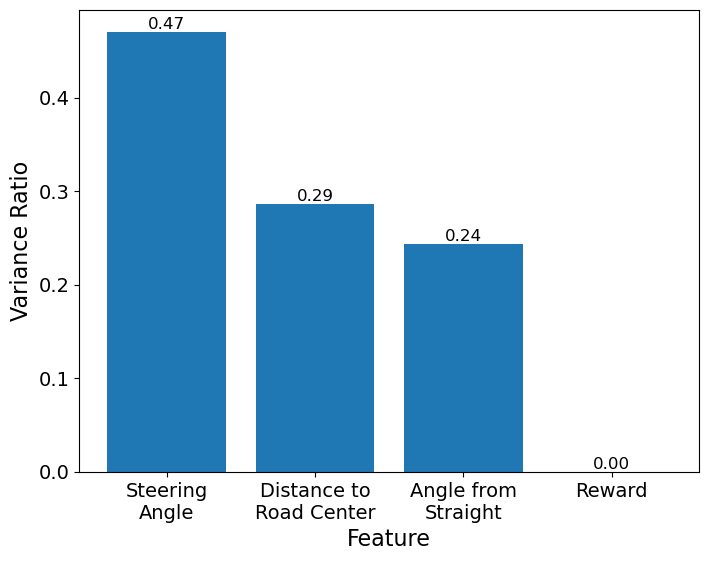

In [242]:
# Perform PCA analysis
def PCA(n, df):
    '''Function for PCA analysis, adapted from Group 27 Workshop 2'''
    pca = decomposition.PCA(n_components=n)
    pca.fit_transform(df)

    sing_vals = pca.singular_values_
    var_ratios = pca.explained_variance_ratio_

    print(f"For {n} components:")
    print(f"Singular values: {sing_vals}")
    print(f"Variance ratios: {var_ratios}")

    return var_ratios

var_ratios4 = PCA(4, df_norm)

# Plot variance ratio v. number of features
plt.figure(figsize=(8, 6))
bars = plt.bar(range(1, len(var_ratios4)+1), var_ratios4)

for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

xlabels = ['Steering\nAngle', 'Distance to\nRoad Center', 'Angle from\nStraight', 'Reward']
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Variance Ratio', fontsize=16)
plt.xticks(range(1, 5), labels=xlabels, ma='center', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [243]:
# Save data into csv
data = df_norm.to_dict(orient='dict')
display(df_norm.head())
save_data_to_csv(foldername="train_data", filename="raw_data_pd.csv", data=data)

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,2.588463,1.026888,2.956561,-0.012300
1,2.588463,1.026888,2.956561,-0.012300
2,2.588463,1.026888,2.956561,-0.012300
3,2.588463,1.026888,2.956561,-0.012300
4,2.588463,1.026888,2.956561,-0.012614


Saved raw_data_pd.csv


## PD - Processed Data

In [244]:
# Perform outlier detection
def detect_outliers(df, feature, window_size, threshold):
    '''Function to detect outliers using rolling statistics for a given feature'''
    rolling_mean = df[feature].rolling(window=window_size).mean()
    rolling_std = df[feature].rolling(window=window_size).std()
    outliers = np.abs(df[feature] - rolling_mean) > threshold * rolling_std
    return outliers

# Define rolling window size and threshold
window_size = 50
threshold = 3

# List of features to apply outlier detection
features = ["steering_angle", "distance_to_road_center", "angle_from_straight_in_rads", "reward"]

# Initialise list for all clean data
clean_data = []

# Apply outlier detection to some features of each simulation run
for fp in csv_fps:
    run_df = pd.read_csv(fp)
    # Drop irrelevant features
    run_df.drop('timestep', axis=1, inplace=True)
    run_df.drop('car_speed', axis=1, inplace=True)
    run_df.drop('total_reward', axis=1, inplace=True)

    outliers_df = pd.DataFrame(index=df.index) # Initialise dataframe to store outlier flags
    
    for feature in features:
        outliers_df[feature] = detect_outliers(run_df, feature, window_size, threshold)
    outliers_combined = outliers_df.any(axis=1) # Combine outliers from all features
    outliers_indices = df.index[outliers_combined].tolist()
    clean_df = run_df.drop(outliers_indices)
    clean_data.append(clean_df)

df = pd.concat(clean_data, ignore_index=True)
display(df)
    

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,1.205219,0.043588,0.769343,0.426165
1,1.205219,0.043588,0.769343,0.426165
2,1.205219,0.043588,0.769343,0.426165
3,1.205219,0.043588,0.769343,0.426165
4,1.205219,0.043588,0.769343,0.425457
...,...,...,...,...
122024,0.068511,0.005207,0.016446,-8.220245
122025,0.067777,0.005244,0.015342,-8.172504
122026,0.067025,0.005278,0.014245,-8.124356
122027,0.066256,0.005310,0.013157,-8.075805


In [245]:
# Remove duplicate data
df = df.drop_duplicates()

display(df)

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,1.205219,0.043588,0.769343,0.426165
4,1.205219,0.043588,0.769343,0.425457
5,1.205531,0.043857,0.766957,0.424230
6,1.206004,0.044350,0.762502,0.415638
7,1.214975,0.045025,0.764728,0.413776
...,...,...,...,...
122024,0.068511,0.005207,0.016446,-8.220245
122025,0.067777,0.005244,0.015342,-8.172504
122026,0.067025,0.005278,0.014245,-8.124356
122027,0.066256,0.005310,0.013157,-8.075805


In [246]:
# Only keep samples with positive rewards
df = df[df['reward'] > 0]

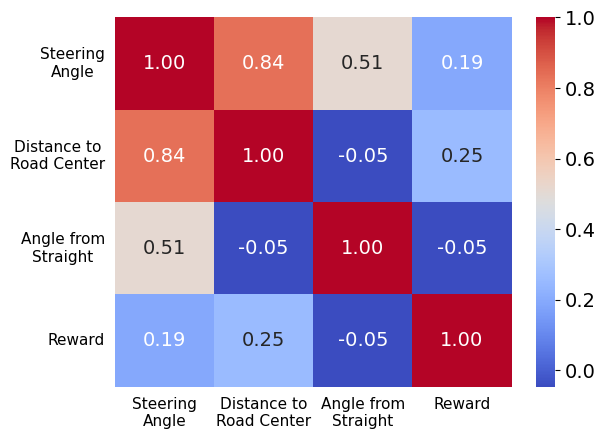

In [247]:
# Compute correlation matrix
corr_matrix = df.corr()

# Visualise matrix
ax = plt.gca()
heatmap = sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            annot_kws={"size": 14})

labels = ['Steering\nAngle', 'Distance to\nRoad Center', 'Angle from\nStraight', 'Reward']
ax.set_xticks([x + 0.5 for x in range(len(labels))])
ax.set_yticks([y + 0.5 for y in range(len(labels))])
ax.set_xticklabels(labels, ma='center', rotation=0, size=11)
ax.set_yticklabels(labels, ma='center', rotation=0, size=11)
ax.tick_params(left=False, bottom=False)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

In [248]:
# Perform data normalisation

print("DNN training data before normalisation:")
display(df)
# Normalise data
scaler = StandardScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Store scaling parameters
scaling_params = {
    'mean': scaler.mean_,
    'scale': scaler.scale_
}

# Save scaling parameters
with open('train_data/processed_data_pd_scaling_params.pkl', 'wb') as file:
    pickle.dump(scaling_params, file)

print("DNN training data after normalisation:")
display(df_norm)

# Print scaling parameters
scaling_params_df = pd.DataFrame(columns=df_norm.columns)
scaling_params_df.loc[len(scaling_params_df)] = scaler.mean_
scaling_params_df.loc[len(scaling_params_df)] = scaler.scale_
scaling_params_df = scaling_params_df.rename(index={0: 'mean', 1: 'scale'})
print("Scaling parameters for normalisation:")
display(scaling_params_df)

DNN training data before normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,1.205219,0.043588,0.769343,0.426165
4,1.205219,0.043588,0.769343,0.425457
5,1.205531,0.043857,0.766957,0.424230
6,1.206004,0.044350,0.762502,0.415638
7,1.214975,0.045025,0.764728,0.413776
...,...,...,...,...
121185,0.715580,0.007239,0.643193,0.458246
121186,0.768742,0.008091,0.687831,0.357374
121187,0.774325,0.009562,0.678709,0.256780
121188,0.779573,0.011016,0.669418,0.156464


DNN training data after normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,2.951861,1.203014,3.481764,-1.856692
1,2.951861,1.203014,3.481764,-1.859236
2,2.952644,1.210898,3.470854,-1.863646
3,2.953835,1.225300,3.450489,-1.894529
4,2.976408,1.245016,3.460665,-1.901220
...,...,...,...,...
113150,1.719868,0.140641,2.905026,-1.741388
113151,1.853628,0.165550,3.109106,-2.103937
113152,1.867676,0.208531,3.067399,-2.465488
113153,1.880882,0.251025,3.024923,-2.826038


Scaling parameters for normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
mean,0.032042,0.002427,0.007774,0.942752
scale,0.397436,0.034215,0.218731,0.278230


For 4 components:
Singular values: [4.79658176e+02 3.61408138e+02 3.03203218e+02 2.43239332e-13]
Variance ratios: [5.08311533e-01 2.88577267e-01 2.03111200e-01 1.30717539e-31]


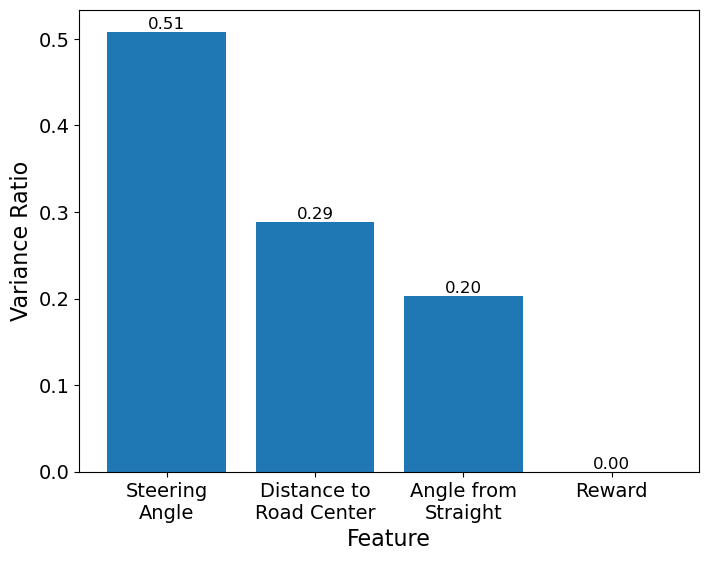

In [249]:
# Perform PCA analysis
def PCA(n, df):
    '''Function for PCA analysis'''
    pca = decomposition.PCA(n_components=n)
    pca.fit_transform(df)

    sing_vals = pca.singular_values_
    var_ratios = pca.explained_variance_ratio_

    print(f"For {n} components:")
    print(f"Singular values: {sing_vals}")
    print(f"Variance ratios: {var_ratios}")

    return var_ratios

var_ratios4 = PCA(4, df_norm)

# Plot variance ratio v. number of features
plt.figure(figsize=(8, 6))
bars = plt.bar(range(1, len(var_ratios4)+1), var_ratios4)

for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

xlabels = ['Steering\nAngle', 'Distance to\nRoad Center', 'Angle from\nStraight', 'Reward']
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Variance Ratio', fontsize=16)
plt.xticks(range(1, 5), labels=xlabels, ma='center', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [250]:
# Save final dataframe as csv to use for training
filename = "train_data/processed_data_pd.csv"
df_norm.to_csv(filename, encoding='utf-8', index=False)

# Feature Analysis

In [251]:
# Read the saved data csvs
raw_df = pd.read_csv("train_data/raw_data_pd.csv")
processed_df = pd.read_csv("train_data/processed_data_pd.csv")

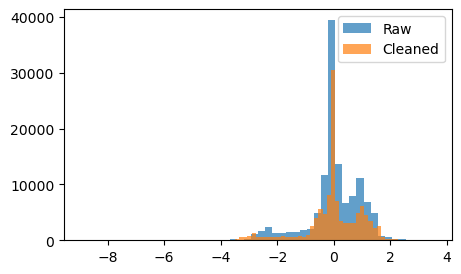

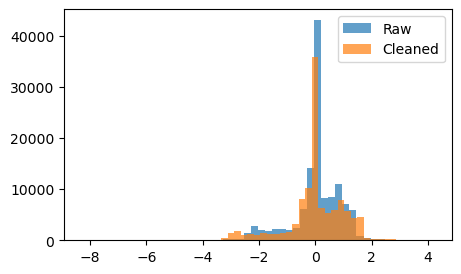

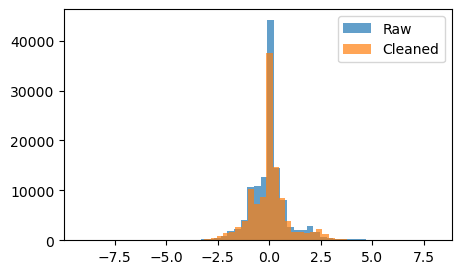

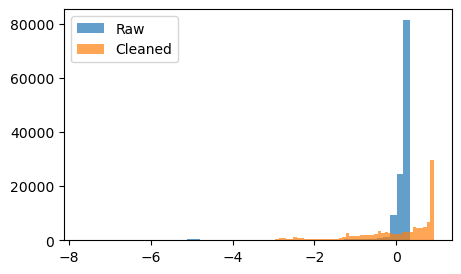

In [252]:
# Plot feature distributions
for feature in raw_df.columns:
    plt.figure(figsize=(5, 3))
    plt.hist(raw_df[feature], bins=50, alpha=0.7, label='Raw')
    plt.hist(processed_df[feature], bins=50, alpha=0.7, label='Cleaned')
    plt.legend()
    plt.show()